In [14]:
pip install tensorflow

  Using cached tensorflow-2.16.2-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.16.2-cp312-cp312-win_amd64.whl.metadata (5.0 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached ml_dtypes-0.3.2-cp312-cp312-win_amd64.whl.metadata (20 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.64.1-cp312-cp312-win_amd64.whl.metadata (3.4 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.4.1-py3-none-any.whl.metadata (5.8 kB)
  Using cached namex-0.0.8

In [15]:
import numpy as np # linear algebra
from sklearn.preprocessing import LabelEncoder
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # to use operating system dependent functionality
import librosa # to extract speech features
import wave # read and write WAV files
import matplotlib.pyplot as plt # to generate the visualizations

# MLP Classifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# LSTM Classifier
import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import *
from keras.src.optimizers import optimizer

# SPEECH EMOTION DETECTION
Speech Emotion Detection (SED) is the task of automatically recognizing and classifying emotions conveyed through speech signals. It involves the use of techniques from signal processing, machine learning, and natural language processing (NLP) to analyze vocal cues and identify the emotional state of a speaker.

### Key Aspects of Speech Emotion Detection:

- **Signal Processing**: Techniques such as feature extraction from audio signals (e.g., MFCC - Mel Frequency Cepstral Coefficients) to capture relevant characteristics related to pitch, intensity, and spectral content that correlate with emotions.

- **Feature Engineering**: Selection and transformation of acoustic features that are relevant for distinguishing different emotional states.

- **Machine Learning and Deep Learning**: Utilization of various models and algorithms, including traditional machine learning methods (e.g., Support Vector Machines, Random Forests) and deep learning architectures (e.g., Convolutional Neural Networks, Recurrent Neural Networks like LSTM), to classify emotions based on extracted features.

- **Emotion Classification**: Assigning one or multiple predefined emotion labels (e.g., happiness, sadness, anger, neutrality) to audio segments based on the analysis of extracted features and model pr
future directions.
edictions.


### RAVDESS Dataset Description

The RAVDESS dataset contains 1440 audio files, structured as follows: 60 trials per actor multiplied by 24 actors, resulting in 1440 files. The dataset comprises recordings from 24 professional actors (12 female and 12 male), each vocalizing two lexically-matched statements in a neutral North American accent. The speech emotions included are calm, happy, sad, angry, fearful, surprise, and disgust, with each emotion expressed at two levels of emotional intensity (normal and strong), along with an additional neutral expression.

#### File Naming Convention

Each file in the dataset has a unique filename format: `03-01-06-01-02-01-12.wav`. Here's the breakdown of the filename identifiers:

- **Modality**: `01` for full-AV (audiovisual), `02` for video-only, `03` for audio-only.
- **Vocal Channel**: `01` for speech, `02` for song.
- **Emotion**: 
  - `01` = neutral
  - `02` = calm
  - `03` = happy
  - `04` = sad
  - `05` = angry
  - `06` = fearful
  - `07` = disgust
  - `08` = surprised
- **Emotional Intensity**: `01` for normal, `02` for strong (Note: 'neutral' emotion has no strong intensity).
- **Statement**: 
  - `01` = "Kids are talking by the door"
  - `02` = "Dogs are sitting by the door"
- **Repetition**: `01` for 1st repetition, `02` for 2nd repetition.
- **Actor**: `01` to `24`. Odd-numbered actors are male, and even-numbered actors are female.

#### Filename Example: `03-01-06-01-02-01-12.wav`

- **Audio-only (03)**
- **Speech (01)**
- **Fearful (06)**
- **Normal intensity (01)**
- **Statement "dogs" (02)**
- **1st Repetition (01)**
- **12th Actor (12)** (Female, as the actor ID number is even)


In [3]:
# Define the path to your RAVDESS dataset
DATASET_PATH = r'C:\Users\sarth\Downloads\voice'


## DATA PREPROCESSING

### Function to Load an Audio File

The `load_audio` function loads an audio file from the specified `file_path` and returns the audio waveform and its sample rate (`sr`). It utilizes the `librosa` library for audio loading and handles exceptions if the file loading fails.

### Function to Extract MFCC Features

The `extract_mfcc` function extracts Mel-Frequency Cepstral Coefficients (MFCC) features from the audio data. MFCCs are commonly used in speech and audio processing to capture the spectral characteristics of sound. This function computes the MFCCs and returns their mean values across time (`axis=0`).

### Dummy Function to Extract Label from Filename

The `extract_label_from_filename` function extracts the emotional label from a given filename based on predefined mappings (`emotion_dict`). It parses the filename and retrieves the emotion label using the third part of the filename (which corresponds to the emotion identifier).

#### Emotion Dictionary:
- `'01': 'neutral'`
- `'02': 'calm'`
- `'03': 'happy'`
- `'04': 'sad'`
- `'05': 'angry'`
- `'06': 'fearful'`
- `'07': 'disgust'`
- `'08': 'surprised'`

This function is used to map numeric identifiers from filenames to human-readable emotional labels, facilitating the labeling of audio data during the processing pipeline.

g the processing pipeline.

coder`.


In [5]:
# Define the path to your RAVDESS dataset


# Function to load an audio file
def load_audio(file_path, sr=22050):
    try:
        audio, sample_rate = librosa.load(file_path, sr=sr)
        return audio, sample_rate
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

# Function to extract MFCC features
def extract_mfcc(audio, sr, n_mfcc=40):
    mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc).T, axis=0)
    return mfccs

# Dummy function to extract label from filename
def extract_label_from_filename(file_name):
    emotion_dict = {
        '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
        '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
    }
    parts = file_name.split('-')
    emotion_label = emotion_dict[parts[2]]
    return emotion_label


## Loading and Processing Audio Dataset
### Iterating Through Audio Files
The code iterates through all `.wav` files located in the `DATASET_PATH` directory and its subdirectories using `os.walk`.
### Extracting Features and Labels
For each audio file:
- **Label Extraction**: The label is extracted from the filename (`filename[7:8] - 1`). This assumes the label information is encoded in a specific position within the filename.  
- **Loading Audio**: The `load_audio` function is called to load the audio file and obtain the audio waveform (`audio`) and its sampling rate (`sr`).
- **Extracting MFCC Features**: If the audio loading is successful (`audio` is not `None`), the `extract_mfcc` function extracts Mel-Frequency Cepstral Coefficients (MFCC) features from the audio.
- **Appending Features and Labels**: Extracted MFCC features (`mfcc_features`) and their corresponding labels (`label`) are appended to lists `X` and `y`, respectively.

### Handling Errors

- **Exception Handling**: If there is an error during any step (e.g., loading audio, extracting features), an error message is printed, and the file is skipped (`except Exception as e`).

### Final Dataset Preparation

- **Conversion to Numpy Arrays**: After processing all audio files, lists `X` and `y` are converted into NumPy arrays (`np.array(X)` and `np.array(y)`).



In [7]:
X=[]
y=[]
for dirname, _, filenames in os.walk(DATASET_PATH):
    for filename in filenames:
        if filename.endswith('.wav'):
            try:
                label = int(filename[7:8]) - 1  # Extract label from filename
                wav_file_path = os.path.join(dirname, filename)
                audio, sr = load_audio(wav_file_path)  # Load audio file
                if audio is not None:
                    mfcc_features = extract_mfcc(audio, sr)  # Extract MFCC features
                    if mfcc_features is not None:
                        X.append(mfcc_features)
                        y.append(label)
            except Exception as e:
                print(f"Error processing {filename}: {e}")

X = np.array(X)
y = np.array(y)

print("Finish Loading the Dataset")
print("X shape:", X.shape)
print("y shape:", y.shape)

Finish Loading the Dataset
X shape: (2880, 40)
y shape: (2880,)


In [9]:
y

array([0, 0, 0, ..., 7, 7, 7])

In [11]:
X

array([[-6.9779260e+02,  5.4890041e+01,  6.6346520e-01, ...,
        -1.7701062e+00, -3.5011320e+00, -1.5380874e+00],
       [-6.9285577e+02,  5.5363899e+01, -1.5483192e+00, ...,
        -3.0869722e+00, -3.2097483e+00, -2.3071594e+00],
       [-6.9158789e+02,  5.8024662e+01,  1.5946463e-01, ...,
        -2.7295372e+00, -3.5089064e+00, -2.2463746e+00],
       ...,
       [-5.4125165e+02,  2.9595709e+01, -1.8001362e+01, ...,
        -3.8906682e-01, -9.7194743e-01, -3.9210208e-03],
       [-4.9265253e+02,  2.3887981e+01, -6.0266590e+00, ...,
         9.1637713e-01, -1.4326899e+00,  1.4300117e+00],
       [-5.1798480e+02,  2.9571215e+01, -3.9096990e+00, ...,
        -1.2455600e-01, -1.8519229e+00,  7.0855033e-01]], dtype=float32)

In [17]:
### Label Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(y_encoded)
##One_hot encoding
y_cat=to_categorical (y_encoded)
print(y_cat)

[0 0 0 ... 7 7 7]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


## Train-Test Split

In [19]:

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=9)

# Print shapes to verify
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


Training set size: 2304 samples
Testing set size: 576 samples
X_train shape: (2304, 40)
X_test shape: (576, 40)


In [21]:
X_train = X_train[..., np.newaxis]
X_test=X_test[...,np.newaxis]

# Conv1D Model for Emotion Recognition

### Model Architecture

The Conv1D model is designed to classify emotions based on audio features extracted using Mel-Frequency Cepstral Coefficients (MFCCs). The architecture consists of:

- **Conv1D Layer**: The first layer has 64 filters with a kernel size of 3 and uses the ReLU activation function. It takes input with a shape corresponding to the MFCC feature dimensions.
- **MaxPooling1D Layer**: This layer with a pool size of 2 reduces the dimensionality of the feature maps.
- **Dropout Layer**: A dropout rate of 0.3 is used to prevent overfitting.
- **Conv1D Layer**: The second Conv1D layer has 128 filters with a kernel size of 3 and uses the ReLU activation function.
- **MaxPooling1D Layer**: Another pooling layer with a pool size of 2.
- **Dropout Layer**: Another dropout layer with a rate of 0.3.
- **Flatten Layer**: Flattens the feature maps into a single vector.
- **Dense Layer**: A dense layer with 128 units and ReLU activation.
- **Dropout Layer**: Dropout with a rate of 0.3.
- **Output Layer**: A dense layer with a number of units equal to the number of emotion classes, using the softmax activation function to output probability distributions for each class.

### Model Compilation

The model is compiled using the Adam optimizer and categorical cross-entropy loss function, which is suitable for multi-class classification problems. The performance metric used is accuracy.

In [23]:

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




C:\Users\sarth\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Adding Channel Dimension for Conv1D

In Conv1D neural networks, adding an additional channel dimension (`np.newaxis`) to input data like MFCC features (`X_train` and `X_test`) is essential. This adjustment ensures compatibility with Conv1D layers, which expect input shapes in the form `(batch_size, sequence_length, num_channels)`. The channel dimension allows Conv1D to effectively apply filters across the temporal dimension of the data, facilitating feature extraction and learning temporal patterns.


In [25]:
X_train = X_train[..., np.newaxis]
X_test=X_test[...,np.newaxis]

### Training the Model

The model is trained using the training data (`X_train` and `y_train`). The training process involves:

- **Epochs**: The model is trained for 100 epochs.
- **Batch Size**: A batch size of 32 is used for each training step.
- **Validation Data**: The model's performance is validated on the validation set (`X_test` and `y_test`) during training to monitor and evaluate its accuracy and loss.


In [27]:

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.1584 - loss: 7.1055 - val_accuracy: 0.2066 - val_loss: 2.0191
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1868 - loss: 2.0571 - val_accuracy: 0.2674 - val_loss: 1.9672
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2083 - loss: 1.9912 - val_accuracy: 0.3090 - val_loss: 1.8931
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2205 - loss: 1.9487 - val_accuracy: 0.2413 - val_loss: 1.8655
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2279 - loss: 1.9341 - val_accuracy: 0.2986 - val_loss: 1.8345
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2546 - loss: 1.9139 - val_accuracy: 0.2691 - val_loss: 1.8204
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2591 - loss: 1.8634 - val_accuracy: 0.3038 - val_loss: 1.8044
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2722 - loss: 1.8660 - val_accuracy: 0.3247 - 

### Model Evaluation

After training, the model is evaluated on the test set to determine its final accuracy. The test accuracy provides an indication of how well the model generalizes to unseen data.

In [29]:

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Print some predictions
for i in range(10):
    print(f"True label: {true_labels[i]}, Predicted label: {predicted_labels[i]}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9168 - loss: 0.3103
Test accuracy: 0.9184027910232544
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
True label: 5, Predicted label: 5
True label: 2, Predicted label: 2
True label: 3, Predicted label: 3
True label: 1, Predicted label: 1
True label: 1, Predicted label: 1
True label: 1, Predicted label: 1
True label: 7, Predicted label: 7
True label: 0, Predicted label: 0
True label: 3, Predicted label: 1
True label: 2, Predicted label: 2



# Model Training and Test Accuracy

The following plot shows the accuracy of the Conv1D model over 100 epochs for both the training and test datasets.ndt)

### Description

- **X-axis (Epoch)**: Represents the number of training epochs. Each epoch is one complete pass through the training dataset.
- **Y-axis (Accuracy)**: Represents the accuracy of the model. Accuracy is the proportion of correctly predicted instances out of the total instances.

### Observations

- **Training Accuracy (Blue Line)**: The training accuracy shows a steady increase as the number of epochs increases. This indicates that the model is learning and improving its performance on the training data.
- **Test Accuracy (Orange Line)**: The test accuracy also shows an increase and follows a similar trend to the training accuracy. This indicates that the model generalizes well to unseen data.
- **Model Performance**: The model achieves over 90% accuracy on both the training and test datasets after 100 epochs, demonstrating its effectiveness in classifying emotions from auficant overfitting.


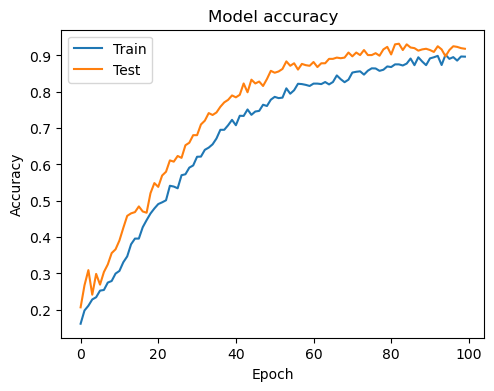

In [31]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

### Conclusion

The graph indicates that the Conv1D model is effective in learning and generalizing the task of emotion recognition from audio features. Both the training and test accuracies show a consistent improvement over the epochs, with the test accuracy closely following the training accuracy, suggesting that the model does not suffer from significant overfitting.

# Confusion Matrix

The following plot shows the confusion matrix for the Conv1D model's predictions on the test dataset.



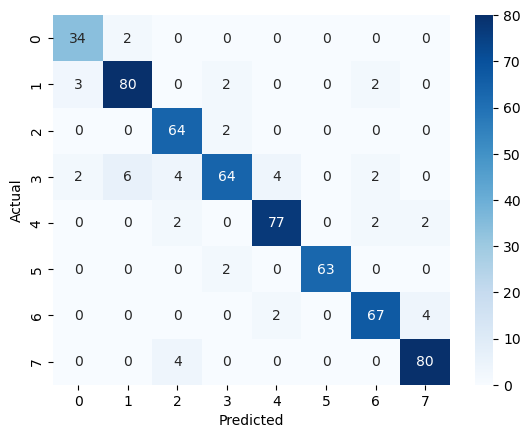

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()




### Description

- **X-axis (Predicted)**: Represents the predicted emotion labels by the model.
- **Y-axis (Actual)**: Represents the actual emotion labels.
- **Color Scale**: The intensity of the color represents the number of instances classified in each category, with darker colors indicating a higher number of instances.

### Emotion Labels
The numerical labels correspond to the following emotions:
- 0: Neutral
- 1: Calm
- 2: Happy
- 3: Sad
- 4: Angry
- 5: Fearful
- 6: Disgust
- 7: Surprised

### Observations

- **High Accuracy**: Most predictions are concentrated along the diagonal, indicating correct classifications.
- **Misclassifications**: Some off-diagonal elements show misclassifications, such as a few instances where 'Neutral' is predicted as 'Calm' or 'Happy'.
- **Confusion**: Specific emotions like 'Sad' and 'Angry' show some level of confusion with other emotions, as indicated by the lighter cells off the diagonal.

### Conclusion

The confusion matrix indicates that the Conv1D model performs well in classifying most of the emotions correctly, with a high number of correct predictions for 'Neutral', 'Sad', and 'Angry'. Some emotions like 'Calm' and 'Happy' have slight confusion with other emotions, but overall, the model demonstrates strong performance in emotion recognition.

In [35]:
# Save the model in the recommended Keras format
model.save('emotion_recognition_model.keras')



# LSTM Model for Emotion Classification

## Model Architecture

- **Input Layer**: The model accepts input with the shape (40, 1), where 40 represents the number of MFCC features extracted from the audio signals.
- **LSTM Layer**: A Long Short-Term Memory (LSTM) layer with 128 units is used. This layer processes the input sequence and outputs the last hidden state.
- **Dense Layer 1**: A fully connected layer with 64 units.
- **Dropout Layer 1**: A dropout layer with a dropout rate of 0.4 is added after the first dense layer to reduce overfitting by randomly setting 40% of the input units to 0 during training.
- **Activation Layer 1**: A ReLU activation function is applied to introduce non-linearity.
- **Dense Layer 2**: Another fully connected layer with 32 units.
- **Dropout Layer 2**: Another dropout layer with a dropout rate of 0.4 is added after the second dense layer to further reduce overfitting.
- **Activation Layer 2**: Another ReLU activation function is applied.
- **Output Layer**: The final output layer consists of 8 units, corresponding to the 8 emotion categories. A softmax activation function is used to output a probability distribution over the emotion categories.

## Model Compilation

- **Loss Function**: The model uses `categorical_crossentropy` as the loss function, which is suitable for multi-class classification problems.
- **Optimizer**: The `Adam` optimizer is used to update the model weights during training. Adam is known for its efficiency and effectiveness in training deep learning models.
- **Metrics**: The `accuracy` metric is used to evaluate the model's performance on the training and validation datasets.

## Usage

The function `create_model_LSTM` initializes and compiles the LSTM model based on the defined architecture. This function can be called to get a compiled model ready for training on the preprocessed dataset.


In [37]:
def create_model_LSTM():
  model = Sequential()
  model.add(LSTM(128, return_sequences=False, input_shape=(40, 1)))
  model.add (Dense (64))
  model.add(Dropout (0.4))
  model.add(Activation('relu'))
  model.add(Dense(32))
  model.add(Dropout (0.4))
  model.add(Activation('relu'))
  model.add(Dense(8))
  model.add(Activation('softmax'))
  # Configures the model for training
  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
  return model

In [39]:
X.shape

(2880, 40)

## Data Preparation for Model Training

### Splitting the Dataset

1. **Determine the Number of Samples**: 
   - `X.shape[0]` gives the total number of samples in the dataset.

2. **Calculate the Number of Training, Validation, and Test Samples**:
   - **Training Samples**: 80% of the total samples are allocated for training.
   - **Validation Samples**: 10% of the total samples are allocated for validation.
   - **Test Samples**: 10% of the total samples are allocated for tef_samples * 0.1)


In [41]:
number_of_samples = X.shape[0]
training_samples = int(number_of_samples * 0.8)
validation_samples = int(number_of_samples * 0.1)
test_samples = int(number_of_samples * 0.1)


#### Reshaping the Training Data

**Expand Dimensions of Training Data**:

- **Reshape the Training Data**: 
  - The training data, `X[:training_samples]`, is reshaped by adding an additional dimension using `np.expand_dims`.
  - This step is crucial to match the input shape required by the LSTM model, which expects a 3D input.
  - The reshaped data ensures compatibility with the LSTM model's input requirements.


In [43]:
w = np.expand_dims(X[:training_samples],-1)
w.shape

(2304, 40, 1)

#### Training the LSTM Model

**Model Initialization**:
- Create the LSTM model by calling the `create_model_LSTM()` function and assign it to `model_A`.

**Model Training**:
- Train the model using the `fit` method:
  - **Training Data**: `w`, which is the reshaped training data.
  - **Training Labels**: `y_cat[:training_samples]`, which are the categorical labels for the training data.
  - **Validation Data**: 
    - Inputs: `np.expand_dims(X[training_samples:training_samples + validation_samples], -1)`, reshaped validation data.
    - Labels: `y_cat[training_samples:training_samples + validation_samples]`, categorical labels for the validation data.
  - **Epochs**: Train the model for 130 epochs.
  - **Shuffle**: Enable shuffling of training data at each epoch to improve generalization.


In [45]:
model_A = create_model_LSTM()
history = model_A.fit(w, y_cat[:training_samples], validation_data=(np.expand_dims(X[training_samples: training_samples+validation_samples], -1),y_cat[training_samples: training_samples+validation_samples]), epochs=130, shuffle=True)

C:\Users\sarth\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.1349 - loss: 2.0852 - val_accuracy: 0.2188 - val_loss: 2.0467
Epoch 2/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.1706 - loss: 2.0386 - val_accuracy: 0.2188 - val_loss: 1.9792
Epoch 3/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2021 - loss: 1.9912 - val_accuracy: 0.2569 - val_loss: 1.9128
Epoch 4/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.2483 - loss: 1.9334 - val_accuracy: 0.3021 - val_loss: 1.8695
Epoch 5/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2637 - loss: 1.9045 - val_accuracy: 0.3056 - val_loss: 1.8294
Epoch 6/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2640 - loss: 1.8780 - val_accuracy: 0.3403 - val_loss: 1.8044
Epoch 7/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.2927 - loss: 1.8321 - val_accuracy: 0.2847 - val_loss: 1.8068
Epoch 8/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.2943 - loss: 1.8198 - val_accuracy: 0.

### Model Evaluation

After training, the model is evaluated on the test set to determine its final accuracy. The test accuracy provides an indication of how well the model generalizes to unseen data.

In [47]:


# Evaluation on test data
evaluation = model_A.evaluate(
    np.expand_dims(X[test_samples:], -1),  # Test data (assuming X is your test data)
    y_cat[test_samples:],  # Test labels in categorical format (assuming y_cat is your test labels)
)

# Printing evaluation metrics
print("Evaluation Metrics:")
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

predictions = model_A.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Print some predictions
for i in range(10):
    print(f"True label: {true_labels[i]}, Predicted label: {predicted_labels[i]}")


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9534 - loss: 0.1384
Evaluation Metrics:
Loss: 0.16391098499298096
Accuracy: 0.9452160596847534
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
True label: 5, Predicted label: 5
True label: 2, Predicted label: 2
True label: 3, Predicted label: 3
True label: 1, Predicted label: 1
True label: 1, Predicted label: 1
True label: 1, Predicted label: 1
True label: 7, Predicted label: 7
True label: 0, Predicted label: 0
True label: 3, Predicted label: 3
True label: 2, Predicted label: 2



# Model Training and Test Accuracy

The following plot shows the accuracy of the Conv1D model over 100 epochs for both the training and test datasets.


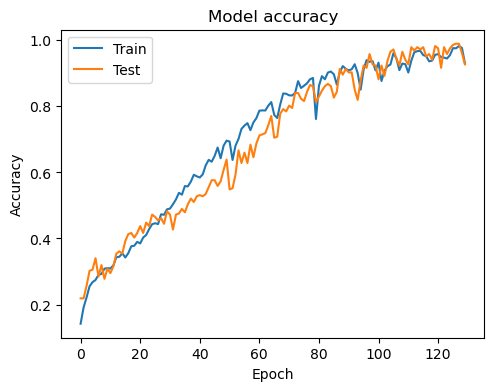

In [49]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

## Description

- **X-axis (Epoch)**: Represents the number of epochs, ranging from 0 to 130
- **Y-axis (Accuracy)**: Represents accuracy, ranging from 0 to 1.0.

## Observations

- **Training Accuracy (Blue Line)**: The 'Train' accuracy line shows a consistent increase over epochs, indicating continuous improvement in performance on the training data.
- **Test Accuracy (Orange Line)**: The 'Test' accuracy line fluctuates but generally follows the upward trend of the 'Train' line. This suggests that the model's performance on unseen test data also improves over epochs, with some variability.

# Confusion Matrix

The following plot shows the confusion matrix for the Conv1D model's predictions on the test dataset.



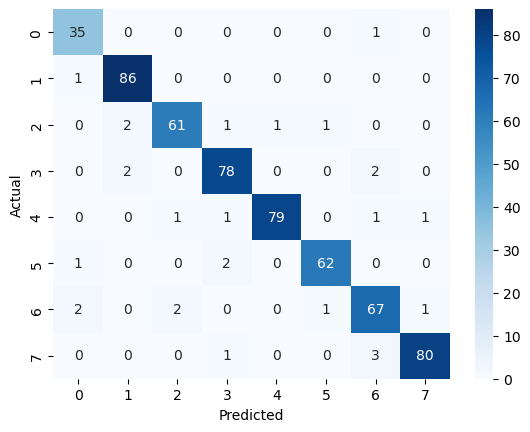

In [51]:

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()




### Description

- **X-axis (Predicted)**: Represents the predicted emotion labels by the model.
- **Y-axis (Actual)**: Represents the actual emotion labels.
- **Color Scale**: The intensity of the color represents the number of instances classified in each category, with darker colors indicating a higher number of instances.

### Emotion Labels
The numerical labels correspond to the following emotions:
- 0: Neutral
- 1: Calm
- 2: Happy
- 3: Sad
- 4: Angry
- 5: Fearful
- 6: Disgust
- 7: Surprised

### Observations

1. **Class 0:**
   - Perfect prediction: 36 instances correctly predicted.
   - No misclassifications.

2. **Class 1 to 7:**
   - The majority of predictions are correct for each class.
   - There is a slight off-diagonal spread indicating some misclassifications to neighboring classes.

3. **General Trend:**
   - High accuracy for each class.
   - Misclassifications mostly occur in adjacent classes, indicating that errors are minor and close to the actual class.

### Conclusions

- **High Model Accuracy:** The LSTM model performs exceptionally well, particularly for class 0 with no misclassifications.
- **Adjacent Class Misclassifications:** The few errors made are predominantly in predicting adjacent classes, suggesting the model's confusion is limited to closely related classes.
- **Strong Performance Across All Classes:** The confusion matrix demonstrates that the model has robust predictive capabilities for a range of classes.


In [55]:
model.save('emotion_recognition_model_LSTM.h5')